In [1]:
import os
import sys
from pathlib import Path
import shutil
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

In [2]:
scene = "data_collection_2"

basepath = Path("/home/shared/")
input_basepath = basepath / "data_raw" / "LAC"
output_basepath = basepath / "data_slam" / "LAC"
input_path = input_basepath / scene
output_path = output_basepath / scene

tum_path = basepath / "data_raw" / "TUM_RGBD" / "rgbd_dataset_freiburg1_desk"

In [3]:
print(sorted(os.listdir(input_path)))
print(sorted(os.listdir(tum_path)))

['data_log.json', 'front_left', 'front_left_semantic', 'front_right', 'front_right_semantic']
['accelerometer.txt', 'depth', 'depth.txt', 'groundtruth.txt', 'rgb', 'rgb.txt']


In [4]:
# LAC dataset
# ==================

# data_collection_1
# ├── front_left
#     ├── 0.png
#     ├── 1.png
#     └── ...
# ├── front_left_semantic
# ├── front_right
# ├── front_right_semantic
# └── data_log.json

# data_log.json
# ------------------
# {
#     "initial_pose": { 4x4 },
#     "lander_pose": { 4x4 },
#     "frames": [
#         {
#             "frame": 0,
#             "timestamp": 0.0,
#             "mission_time": 0.0,
#             "pose": { 4x4 },
#             "imu": { 1x6 },
#         },
#         ...
#     ]
# }

In [5]:
# TUM dataset
# ==================

# rgbd_dataset_freiburg1_desk
# ├── depth
# ├── rgb
# ├── accelerometer.txt
# ├── depth.txt
# ├── groudtruth.txt
# └── rgb.txt

# accelerometer.txt
# ------------------
# # accelerometer data
# # file: 'rgbd_dataset_freiburg1_desk.bag'
# # timestamp ax ay az
# 1305031449.564825 -0.083818 7.244229 -6.657506

# depth.txt
# ------------------
# # depth maps
# # file: 'rgbd_dataset_freiburg1_desk.bag'
# # timestamp filename
# 1305031453.374112 depth/1305031453.374112.png

# groundtruth.txt
# ------------------
# # ground truth trajectory
# # file: 'rgbd_dataset_freiburg1_desk.bag'
# # timestamp tx ty tz qx qy qz qw
# 1305031449.7996 1.2334 -0.0113 1.6941 0.7907 0.4393 -0.1770 -0.3879

# rgb.txt
# ------------------
# # # color images
# # file: 'rgbd_dataset_freiburg1_desk.bag'
# # timestamp filename
# 1305031452.791720 rgb/1305031452.791720.png

In [6]:
start_idx = 34

# RGB
# ------------------
camera_dir_in = "front_left"
camera_dir_out = camera_dir_in + "_rgb"
shutil.copytree(input_path / camera_dir_in, output_path / camera_dir_out, dirs_exist_ok=True)
# Remove up to start_idx
for i in range(start_idx):
    os.remove(output_path / camera_dir_out / f"{i}.png")
 
with open(input_path / "data_log.json", "r") as f:
    data = json.load(f)
    
prec = 6

with open(output_path / "rgb.txt", "w") as f_rgb, open(output_path / "groundtruth.txt", "w") as f_gt:

    f_rgb.write("# color images\n")
    f_rgb.write(f"# file: '{scene}'\n")
    f_rgb.write(f"# timestamp".ljust(20) + " filename\n")

    f_gt.write("# ground truth trajectory\n")
    f_gt.write(f"# file: '{scene}'\n")
    f_gt.write(f"# timestamp".ljust(20))
    for x in ("tx", "ty", "tz", "qx", "qy", "qz", "qw"):
        f_gt.write(" " + x.ljust(prec+3))
    f_gt.write("\n")

    for frame in data["frames"]:
        if frame["frame"] < start_idx:
            continue
        tstamp = frame["mission_time"]
        frame_idx = frame["frame"]

        f_rgb.write(str(tstamp).ljust(20, "0") + f" {camera_dir_out}/{frame_idx}.png\n")    

        pose = np.array(frame["pose"])
        t = pose[:3, 3]
        rot = pose[:3, :3]

        r = R.from_matrix(rot)
        q = r.as_quat(scalar_first=False)

        f_gt.write(str(tstamp).ljust(20, "0"))
        for x in t:
            f_gt.write(" " + f"{x.round(prec):+}".ljust(prec+3, "0"))
        for x in q:
            f_gt.write(" " + f"{x.round(prec):+}".ljust(prec+3, "0"))
        f_gt.write("\n")


In [7]:
W, H = 1280, 720
FOV = 1.22  # [rad]
BASELINE = 0.162  # [m]

fx = W / (2 * np.tan(FOV / 2))
fy = H / (2 * np.tan(FOV / 2))
cx = W / 2
cy = H / 2

distortion = [0, 0, 0, 0, 0]
print(round(fx, 2), round(fy, 2))
print(round(cx, 2), round(cy, 2))
print(distortion)

915.7 515.08
640.0 360.0
[0, 0, 0, 0, 0]


In [8]:
import torch
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

from src.mono_estimators import get_mono_depth_estimator
from thirdparty.glorie_slam import config

config_path = "configs/LAC/data_collection_1.yaml"
cfg = config.load_config(config_path, "configs/splat_slam.yaml")

In [9]:
def predict_mono_depth(model,idx,input,cfg,device):
    '''
    input: tensor (1,3,H,W)
    '''
    depth_model = cfg["mono_prior"]["depth"]
    # output_dir = f"{cfg['data']['output']}/{cfg['scene']}"
    if depth_model == "omnidata":
        # s = cfg["cam"]["H_out"]
        # image_size = (s,s)
        image_size = (512,512)
        input_size = input.shape[-2:]
        trans_totensor = transforms.Compose([transforms.Resize(image_size),
                                            transforms.Normalize(mean=0.5, std=0.5)])
        img_tensor = trans_totensor(input).to(device)
        output = model(img_tensor).clamp(min=0, max=1)
        output = F.interpolate(output.unsqueeze(0), input_size, mode='bicubic').squeeze(0)
        output = output.clamp(0,1).squeeze() #[H,W]
    else:
        # If use other mono depth estimator as prior, predict the mono depth here
        raise NotImplementedError
    
    # output_path_np = f"{output_dir}/mono_priors/depths/{idx:05d}.npy"
    # final_depth = output.detach().cpu().float().numpy()
    # np.save(output_path_np, final_depth)
    
    return output


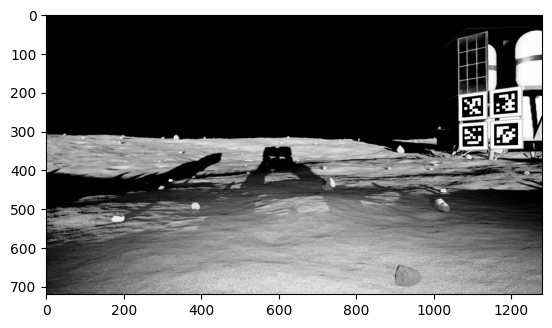

In [10]:
import cv2
tstamp = 34
camera_dir_out = camera_dir_in + "_rgb"
color_path = output_basepath / scene / camera_dir_out / f"{tstamp}.png"
color_data_fullsize = cv2.imread(color_path.as_posix())
# Show
plt.imshow(color_data_fullsize)

In [11]:
mono_depth_estimator = get_mono_depth_estimator(cfg)
device = cfg["device"]
tstamp = 34
image = torch.from_numpy(color_data_fullsize).permute(2,0,1).unsqueeze(0).float() / 255
mono_depth = predict_mono_depth(mono_depth_estimator,tstamp,image,cfg, device)

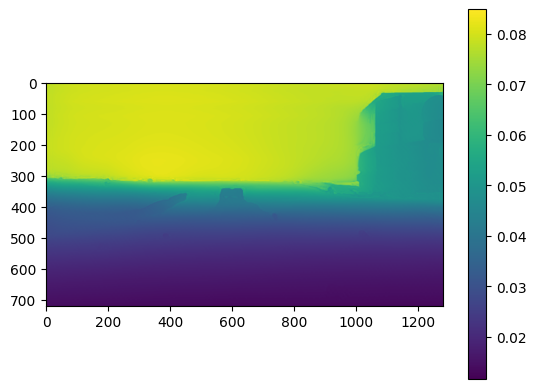

In [12]:
plt.imshow(mono_depth.detach().cpu().numpy())
plt.colorbar()

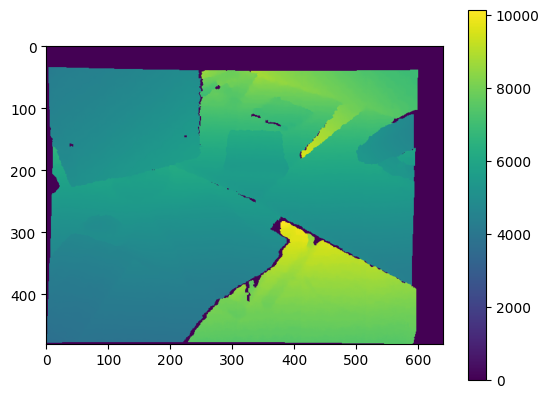

In [13]:
depth_path = tum_path / "depth"
depth_path = depth_path / sorted(os.listdir(depth_path))[0]
depth_data = cv2.imread(depth_path.as_posix(), cv2.IMREAD_UNCHANGED)
plt.imshow(depth_data)
plt.colorbar()

In [14]:
# camera_dir_out = camera_dir_in + "_depth"
# output_path = output_basepath / scene / camera_dir_out / f"{idx}.png"
# output = (output * 255).byte().cpu().numpy()
# im = Image.fromarray(output)
# im.save(output_path)

In [15]:
# tstamp = 34
# camera_dir_out = camera_dir_in + "_depth"
# depth_scale = cfg["cam"]["png_depth_scale"]
# depth_path = output_basepath / scene / camera_dir_out / f"{tstamp}.png"
# depth_data = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
# depth_data = depth_data.astype(np.float32) / depth_scale

## Video

In [ ]:
import cv2
import os
import glob

# Path to the images
image_folder = "/home/shared/outputs/guillemc/LAC/data_collection_1/online_plots"

# Get image files and sort them numerically
image_files = sorted(
    glob.glob(os.path.join(image_folder, "..", "*.png")),
    key=lambda x: int(os.path.basename(x).split(".")[0])  # Extract number and sort
)

# Read the first image to get dimensions
frame = cv2.imread(image_files[0])
height, width, layers = frame.shape

# Define video writer (MP4, 10 FPS)
video_path = os.path.join(image_folder, "output_video.mp4")
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
video = cv2.VideoWriter(video_path, fourcc, 10, (width, height))  # Adjust FPS if needed

# Add images to the video
for file in image_files:
    img = cv2.imread(file)
    video.write(img)

# Release the video writer
video.release()
print(f"Video saved at {video_path}")

Video saved at /home/shared/outputs/guillemc/LAC/data_collection_1/online_plots/output_video.mp4
